# Process the ATL06-SR data prior to DEM Sampling
________________________
 
Some of this code was originally adapted by Hannah Besso from code written by David Shean in 2021
______________

### Steps:  
* Reproject to a local UTM coordinate reference system
* Crop lakes due to extreme negative ATL06-SR values over Hetch Hetchy  
* Label ATL06-SR data as snow-on (snow_presence = 1) or snow-off (snow_presence = 0) based on snow presence at CDEC sites.  

### Import necessary packages:

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy.stats
from astropy.time import Time
import datetime
import pickle

In [3]:
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', None)

### Define a funtion for calculating the day of the water year:

In [7]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

### Load ATL06-SR Data:
This is the file that was output by the Data_Access_SR-ATL06.ipynb notebook

In [75]:
atl06sr = pickle.load(open('../data/ATL06sr/tuolumne_all_sr-atl06-09282022.pkl', 'rb'))

### Load a polygon of the study area:

In [50]:
outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

In [51]:
atl06sr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Reproject from WGS84 (4326) to UTM Zone 11 N (32611):

In [76]:
atl06sr_gdf = atl06sr.to_crs('epsg:32611')

### Add the Day of Water Year to the dataframe:

In [77]:
add_dowy(atl06sr_gdf)

Adding Day of Water Year (DOWY)


In [13]:
tuol_area = outline_gdf['geometry'].area/ 10**6
tuol_area

0    1181.214
dtype: float64

### Plot the ATL06-SR data:

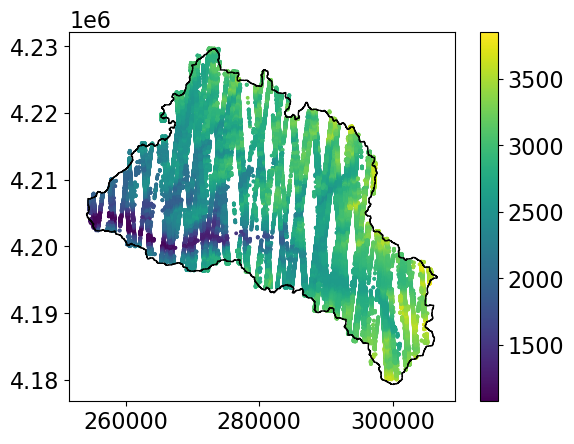

In [20]:
fig, ax = plt.subplots()

atl06sr_gdf.plot(column='h_mean', ax=ax, markersize=3, legend=True)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k');

## Mask out Hetch Hetchy (and other lakes/waterbodies)  
There were large negative difference values over Hetch Hetchy, likely due to water level changes and potentially ATL06-SR returns from below the water surface.  
Lakes layer from https://data.cnra.ca.gov/dataset/california-lakes

In [16]:
lakes = pickle.load(open('../../data/misc/lakes_tuolumne.pkl', 'rb'))

In [17]:
lakes.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Preserve the time index:

In [78]:
atl06sr_gdf['time'] = atl06sr_gdf.index

### Remove data over lakes, which resets to a numerical index:

In [79]:
atl06sr_gdf = gpd.overlay(atl06sr_gdf, lakes, how='difference')

### Set the preserved time column as the index:

In [80]:
atl06sr_gdf = atl06sr_gdf.set_index('time')

In [81]:
atl06sr_gdf.head(2)

,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry,doy,decyear,dowy
time,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,4.215353e+06,0.033182,265,2.488094e+07,0,0.0,210188,3.0,-0.018228,2501.377184,4,30,1,0.091912,15,POINT (269304.074 4196719.705),288,2018.788969,15
2018-10-15 23:22:20.021811344,4.215373e+06,0.028329,265,2.488094e+07,0,0.0,210189,3.0,-0.010939,2501.116873,4,30,1,0.109110,18,POINT (269302.684 4196739.709),288,2018.788969,15


### Plot the ATL06-SR data excluding lakes:

<AxesSubplot: >

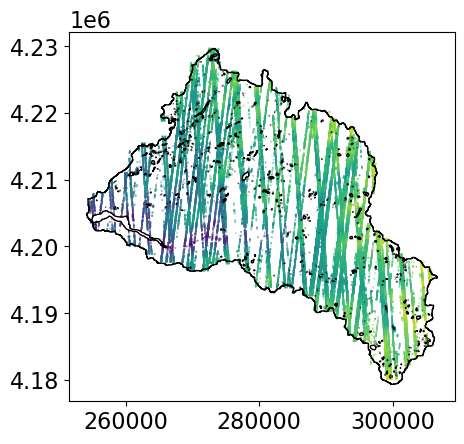

In [23]:
fig, ax = plt.subplots()

atl06sr_gdf.plot(ax=ax, column='h_mean', markersize=0.01)
outline_gdf.plot(ax=ax, facecolor='none')
lakes.plot(ax=ax, facecolor='none')

### Load CDEC data, preprocessed in AUX_dataclean.ipynb

In [57]:
snwd = pickle.load(open('../data/CDEC/cdec_gdf.pkl', 'rb'))

In [25]:
snwd.head(2)

,tum_m,dan_m,doy,decyear,dowy,dan_clean
Date,,,,,,
2018-10-01,0.0254,-0.0508,274.0,2018.747945,1.0,-0.0508
2018-10-02,0.0000,NaN,275.0,2018.750685,2.0,NaN


### Plot the Dana and Tuolumne snow depth

Text(0, 0.5, 'Snow Depth m')

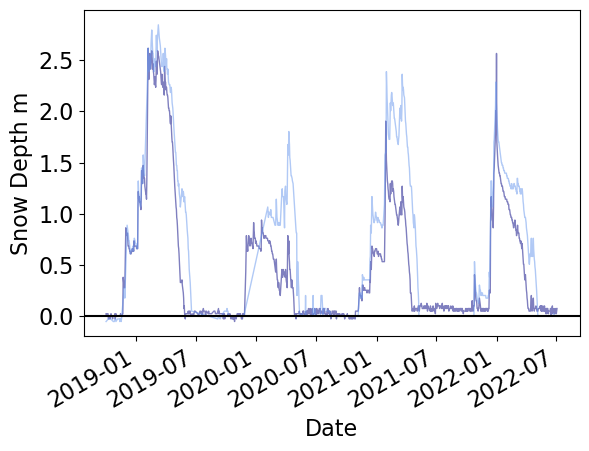

In [29]:
fig, ax = plt.subplots()
snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='navy', lw=1)
snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=0.5, color='cornflowerblue', lw=1)
ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')

### Determine average snow-free dates

In [58]:
idx_st = (snwd[['tum_m', 'dan_clean']] < 0.1).all(axis=1)

<AxesSubplot: >

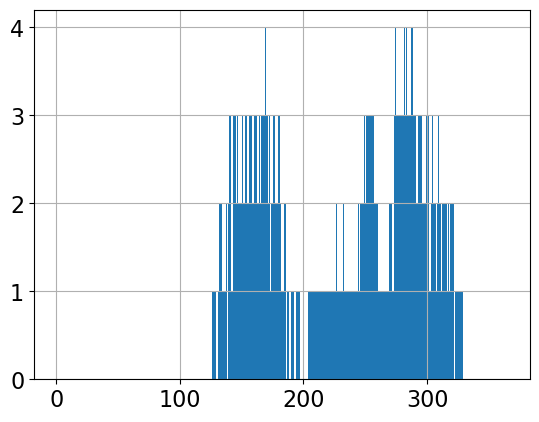

In [31]:
snwd[idx_st]['doy'].hist(bins=365, range=(0,365))

In [32]:
# Define the snowfree range of days:
snowfree_doy_range = (140,340)

In [33]:
snowoff_days_percent = (snowfree_doy_range[1] - snowfree_doy_range[0]) / 360 * 100
snowoff_days_percent

55.55555555555556

### Label data as snow off or snow on:

In [82]:
idx = (atl06sr_gdf['doy'] >= snowfree_doy_range[0]) & (atl06sr_gdf['doy'] <= snowfree_doy_range[1])

In [83]:
# Create a new column named "snow_presence" and set all values to 0:
atl06sr_gdf['snow_presence'] = 0
# Change "snow_presence" value to 1 for dates where there is snow at the CDEC sites:
atl06sr_gdf.loc[~idx, 'snow_presence'] = 1

In [84]:
atl06sr_gdf.head(2)

,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry,doy,decyear,dowy,snow_presence
time,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,4.215353e+06,0.033182,265,2.488094e+07,0,0.0,210188,3.0,-0.018228,2501.377184,4,30,1,0.091912,15,POINT (269304.074 4196719.705),288,2018.788969,15,0
2018-10-15 23:22:20.021811344,4.215373e+06,0.028329,265,2.488094e+07,0,0.0,210189,3.0,-0.010939,2501.116873,4,30,1,0.109110,18,POINT (269302.684 4196739.709),288,2018.788969,15,0


### Plot snow-on and snow-off acquisition dates as a sanity check:

Text(0.5, 1.0, 'Snow On')

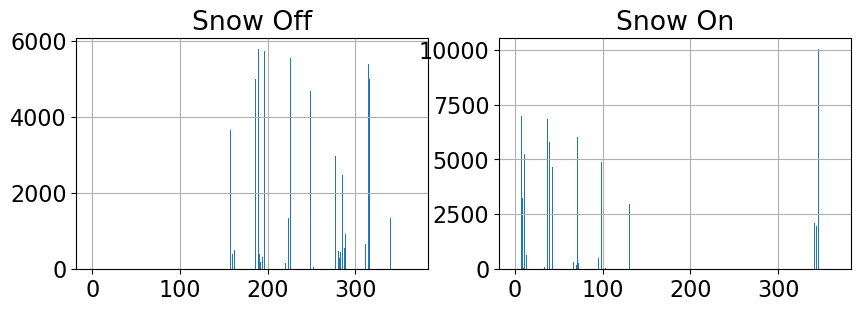

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 0].hist(bins=365, range=(0,365), ax=ax[0])
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 1].hist(bins=365, range=(0,365), ax=ax[1])
ax[0].set_title('Snow Off')
ax[1].set_title('Snow On')

### Save this dataset for use in the next notebook:  

In [48]:
# Save progress: save ATL06SR file prior to DEM differencing (done on Sept 29, 2022 to save my progress in this notebook temporarily)

atl06sr_temp_fn = '../../data/atl06/tuolumne_all_sr-atl06-09282022_processed_wo-dems.pkl'

with open(atl06sr_temp_fn, 'wb') as f:
    pickle.dump(atl06sr_gdf, f)

## Proceed to next notebook to sample the snow-off DTM at each ATL06SR point:  
**ATL06SR_sample_raster.ipynb**